In [1]:
import os
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

from PyPDF2 import PdfFileReader
import fitz
import time

import pandas as pd

import tabula
from pdfminer.high_level import extract_text
import pdfplumber
import pytesseract
from pdf2image import convert_from_path


In [21]:
def save_file(path, content):
    with open(path, 'wb') as f:
        f.write(content)

In [86]:
runtime = []
def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        end = time.time()
        diff = end - start
        runtime.append({'function': func.__name__, 'time':round(diff, 4)})
        # print('Function: {0} run time: {1} seconds'.format(
        #     func.__name__, diff))
        return res
    return wrapper

In [87]:
@timeit
def PDF2TextCustom(path):
    # convert pdf to text
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

In [88]:
@timeit
def PDF2TextPyPDF2(path):
    # convert pdf to text with pypdf2
    with open(path, 'rb') as f:
        pdf = PdfFileReader(f)
        info = pdf.getDocumentInfo()
        number_of_pages = pdf.getNumPages()

        text = ''
        for i in range(number_of_pages):
            page = pdf.getPage(i)
            text += page.extractText()
    return text

In [89]:
@timeit
def PDF2TextPyMuPDF(path):
    text = ''
    with fitz.open(path) as doc:
        for page in doc:
            text += page.get_text()
    return text

In [90]:
@timeit
def PDF2TextTabula(path):
    # convert pdf to text with tabula
    
    df = tabula.read_pdf(path, pages='all')
    return df

In [91]:
@timeit
def PDF2TextPDFMiner(path):
    # convert pdf to text with pdfminer
    
    text = extract_text(path)
    return text

In [92]:
@timeit
def PDF2TextPDFPlumber(path):
    # convert pdf to text with pdfplumber
    with pdfplumber.open(path) as pdf:
        text = ''
        for page in pdf.pages:
            text += page.extract_text()
    return text

In [93]:
@timeit
def PDF2TextPDF2Image(path):
    # convert pdf to text with pdf2image
    
    images = convert_from_path(path)
    text = ''
    for image in images:
        text += pytesseract.image_to_string(image)
    return text

In [101]:
def run():
    runtime.clear()
    path = 'sample.pdf'
    text = PDF2TextCustom(path)
    text = PDF2TextPyPDF2(path)
    text = PDF2TextPyMuPDF(path)
    text = PDF2TextTabula(path)
    text = PDF2TextPDFMiner(path)
    text = PDF2TextPDFPlumber(path)
    # text = PDF2TextPDF2Image(path)
    print(runtime)

In [95]:
# visualize the result by matplotlib
import matplotlib.pyplot as plt
import numpy as np

def visualize():
    # set size of the figure
    plt.rcParams['figure.figsize'] = [10, 5]
    
    # show all the results in a bar chart
    labels = ['Custom', 'PyPDF2', 'PyMuPDF', 'Tabula', 'PDFMiner', 'PDFPlumber']

    # run time in seconds
    run_time = [x['time'] for x in runtime]
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, run_time, width, label='Run Time')

    # show the value on top of the bar
    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                    

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Run Time (seconds)')
    ax.set_title('Run Time Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    
    plt.show()

Got stderr: Dec 10, 2022 12:50:47 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Dec 10, 2022 12:50:47 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Dec 10, 2022 12:50:47 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Dec 10, 2022 12:50:47 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Dec 10, 2022 12:50:47 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Dec 10, 2022 12:50:48 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode
Dec 10, 2022 12:50:48 AM org.apache.pdfbox.pdmodel.font.PDSimpleFont toUnicode



[{'function': 'PDF2TextCustom', 'time': 0.2268}, {'function': 'PDF2TextPyPDF2', 'time': 0.0574}, {'function': 'PDF2TextPyMuPDF', 'time': 0.0113}, {'function': 'PDF2TextTabula', 'time': 1.9899}, {'function': 'PDF2TextPDFMiner', 'time': 0.2293}, {'function': 'PDF2TextPDFPlumber', 'time': 0.2685}]


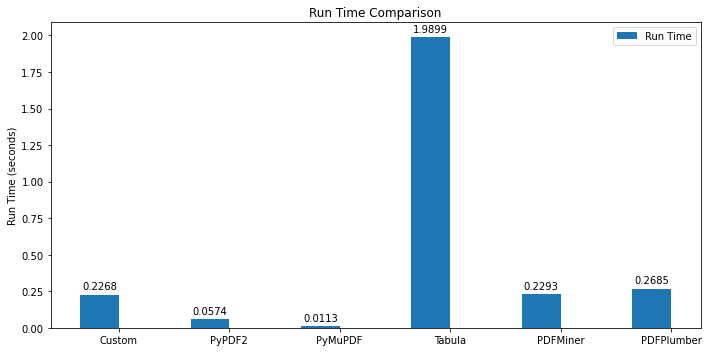

In [102]:

if __name__ == '__main__':
    run()
    visualize()